## Tutorial 2: Training segmentation model for 2018 Data Science Bowl dataset.

### Introduction

This is a quick walkthrough notebook to demonstrate how to train U-Net segmentation model on Data Science Bowl 18 Dataset using PyTorch! At the end of this tutorial, you are expected to get `bestmodel.pt` file inside `model` folder.

### Table of contents

- [Imports](#imports)
- [Load Data Science Bowl 18 Dataset](#load-data-science-bowl-18-dataset)
- [Define dataloaders](#define-dataloaders)
- [Define loss](#define-loss)
- [Load model](#load-model)
- [Start training loop](#start-training-loop)
- [Inference state](#inference-state)
- [Mobile optimization](#mobile-optimization)

#### Imports

In [1]:
import os
import numpy as np
from tqdm import tqdm as tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.mobile_optimizer import optimize_for_mobile
from farabio.data.biodatasets import DSB18Dataset
from farabio.models.segmentation import deeplabv3_mobilenetv2

#### Load Data Science Bowl 18 Dataset

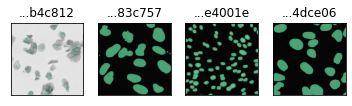

In [2]:
_path = "/home/data/07_SSD4TB/public-datasets/data-science-bowl-2018/"

train_dataset = DSB18Dataset(_path, transform=None, download=False, mode="train", show=True)
valid_dataset = DSB18Dataset(_path, transform=None, download=False, mode="val", show=False)

#### Define dataloaders

In [7]:
train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True, drop_last=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=8, drop_last=True)

#### Define loss

In [4]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE


class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)        #???????
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice


class IoU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoU, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return IoU

#### Load model

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = deeplabv3_mobilenetv2(in_channels=3, out_channels=1).to(device)

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)
print("model is ready!")

Let's use 6 GPUs!
model is ready!


#### Start training loop

In [8]:
if not os.path.exists("model"):
    os.makedirs("model")
    
#from engine import evaluate
criterion = DiceLoss()
accuracy_metric = IoU()
num_epochs = 1
valid_loss_min = np.Inf

checkpoint_path = 'model/chkpoint_'
best_model_path = 'model/bestmodel.pt'

total_train_loss = []
total_train_score = []
total_valid_loss = []
total_valid_score = []

losses_value = 0
for epoch in range(num_epochs):
    train_loss = []
    train_score = []
    valid_loss = []
    valid_score = []
    #<-----------Training Loop---------------------------->
    pbar = tqdm(train_loader, desc = 'description')
    for x_train, y_train,fname in pbar:
        x_train = torch.autograd.Variable(x_train).to(device)
        y_train = torch.autograd.Variable(y_train).to(device)
        optimizer.zero_grad()
        output = model(x_train)
        #Loss
        loss = criterion(output, y_train)
        losses_value = loss.item()
        #Score
        score = accuracy_metric(output,y_train)
        loss.backward()
        optimizer.step()
        train_loss.append(losses_value)
        train_score.append(score.item())
        #train_score.append(score)
        pbar.set_description(f"Epoch: {epoch+1}, loss: {losses_value}, IoU: {score}")

    #<---------------Validation Loop---------------------->
    with torch.no_grad():
        for image,mask,fname in valid_loader:
            image = torch.autograd.Variable(image).to(device)
            mask = torch.autograd.Variable(mask).to(device)
            output = model(image)
            ## Compute Loss Value.
            loss = criterion(output, mask)
            losses_value = loss.item()
            ## Compute Accuracy Score
            score = accuracy_metric(output,mask)
            valid_loss.append(losses_value)
            valid_score.append(score.item())

    total_train_loss.append(np.mean(train_loss))
    total_train_score.append(np.mean(train_score))
    total_valid_loss.append(np.mean(valid_loss))
    total_valid_score.append(np.mean(valid_score))
    print(f"\n###############Train Loss: {total_train_loss[-1]}, Train IOU: {total_train_score[-1]}###############")
    print(f"###############Valid Loss: {total_valid_loss[-1]}, Valid IOU: {total_valid_score[-1]}###############")

    #Save best model Checkpoint    
    ## TODO: save the model if validation loss has decreased
    if total_valid_loss[-1] <= valid_loss_min:
        torch.save(model.module.state_dict(), best_model_path)
        valid_loss_min = total_valid_loss[-1]
        
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,total_valid_loss[-1]))

Epoch: 1, loss: 0.2098414352208079, IoU: 0.6531096606597259: 100%|█| 67/67 [03:4



###############Train Loss: 0.23224690864997125, Train IOU: 0.6276027080353989###############
###############Valid Loss: 0.24058675459423834, Valid IOU: 0.6174136322299519###############
Validation loss decreased (0.240587 --> 0.240587).  Saving model ...


#### Inference state

In [9]:
model_test = deeplabv3_mobilenetv2(in_channels=3, out_channels=1)
model_test.load_state_dict(torch.load(best_model_path))
model_test.eval()
print("ready for inference")

ready for inference


#### Mobile optimization

In [10]:
example_tensor = torch.rand(1,3,256,256)
model_name_optim = 'deeplab_mobilenet_optimized.ptl'

traced_script_module = torch.jit.trace(model_test, example_tensor)
traced_script_module_optimized = optimize_for_mobile(traced_script_module)
traced_script_module_optimized._save_for_lite_interpreter(model_name_optim)